# Compressed Skinning for Facial Blendshapes

Simple re-implementation of the paper "Compressed Skinning for Facial Blendshapes" (Siggraph 2024 conference paper)


## Notation

$A$: delta Blendshape \
$B$: sparse matrix (transforms for proxy bones) \
$C$: sparse matrix (weight for vertices) \
$S$: Number of Blendshape \
$N$: Number of vertices \
$P$: Number of proxy bones

## Goal

$\min_{B,C} || A = B\cdot C ||_F^2 $

where \
$A$ dimension: $\mathbb{R} \in 3S \times N$ \
$B$ dimension: $\mathbb{R} \in 3S \times 4P$ \
$C$ dimesntion: $\mathbb{R} \in 4P \times N$


In [1]:
import os
import sys
from pathlib import Path
abs_path = str(Path.cwd().parents[0].absolute())
sys.path+=[abs_path, f'{abs_path}/utils']

import numpy as np
import torch
import random
from tqdm import tqdm

from utils import ICT_face_model
from utils.matplotlib_rnd import (
    plot_image_array,
    plot_image_array_seg
)

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [2]:
ict_model = ICT_face_model()

device='cuda:0'

In [3]:
V = ict_model.neutral_verts
F = ict_model.faces
nV= V.shape[0]
print("face model:")
print("\tvertices:", *V.shape)
print("\tfaces:", *F.shape)

A = ict_model.exp_basis[:,:V.shape[0]] # deltas
A = torch.tensor(A)
A_ = A.to(device)
print("\tBlendshape:", *A.shape)

face model:
	vertices: 11248 3
	faces: 22288 3
	Blendshape: 53 11248 3


## Initialization

In [ ]:
def softmax(x, dim=-1):
    exp_x = torch.exp(x)
    return exp_x / exp_x.sum(dim, keepdim=True)

def create_BN(B):
    N = torch.tensor([
        [ 0., -1.,  1., 1.],
        [ 1.,  0., -1., 1.],
        [-1.,  1.,  0., 1.]
    ]).to(B.device)
    BN = N[...,None,None].repeat(1, 1, B.shape[1], B.shape[2])
    #N = torch.zeros(3, 4, B.shape[1], B.shape[2])
    # N[0,1], N[0,2], N[0,3] = -B[2], B[1], B[3]
    # N[1,0], N[1,2], N[1,3] = B[2], -B[0], B[4]
    # N[2,0], N[2,1], N[2,3] = -B[1], B[0], B[5]
    BN[0,1], BN[0,2], BN[0,3] = N[0,1]*B[2], N[0,2]*B[1], N[0,3]*B[3]
    BN[1,0], BN[1,2], BN[1,3] = N[1,0]*B[2], N[1,2]*B[0], N[1,3]*B[4]
    BN[2,0], BN[2,1], BN[2,3] = N[2,0]*B[1], N[2,1]*B[0], N[2,3]*B[5]
    BN = BN.permute(2, 0, 1, 3)
    return BN

### test

In [13]:
P = 40
B = softmax(torch.randn(6, A.shape[0], P))
print("B:")
print("\tshape:", *B.shape)
print("\tmin:", B.min())
print("\tmax:", B.max())

BN = create_BN(B)
print("B into matrix form:")
print("\tshape:", *BN.shape)
print("\tmin:", BN.min())
print("\tmax:", BN.max())

C = torch.randn(P, A.shape[1])
C = softmax(C, dim=1)
print("C:")
print("\tshape:", *C.shape, "will be repeated x 4")
print("\tmin:", C.min())
print("\tmax:", C.max())

B=B.to(device).requires_grad_()
C=C.to(device).requires_grad_()

B:
	shape: 6 53 40
	min: tensor(0.0003)
	max: tensor(0.4980)
B into matrix form:
	shape: 53 3 4 40
	min: tensor(-0.4654)
	max: tensor(0.4980)
C:
	shape: 40 11248 will be repeated x 4
	min: tensor(3.2380e-07)
	max: tensor(0.0042)


In [7]:
def laplacian_and_adjacency(vertices: torch.Tensor, faces: torch.Tensor):
    """
    Reference: https://pytorch3d.readthedocs.io/en/latest/_modules/pytorch3d/ops/laplacian_matrices.html
    
    Computes the laplacian matrix.
    The definition of the laplacian is
    L[i, j] =    -1       , if i == j
    L[i, j] = 1 / deg(i)  , if (i, j) is an edge
    L[i, j] =    0        , otherwise
    where deg(i) is the degree of the i-th vertex in the graph.

    Args:
        vertices: number of vertices (N) of the mesh (N, 3)
        faces: number of faces (T) of the mesh (T, 3)
        edges:   tensor of shape (E, 2) containing the vertex indices of each edge
    Returns:
        L: Sparse FloatTensor of shape (V, V)
        A: Adjacency matrix (V, V)
    """
    V = vertices.shape[0]
    F = faces
        
    e0 = F[:, [0,1,2]].reshape(-1)
    e1 = F[:, [2,1,0]].reshape(-1)
    
    idx01 = torch.stack([e0, e1], dim=1)  # (E, 2)
    idx10 = torch.stack([e1, e0], dim=1)  # (E, 2)
    
    idx = torch.cat([idx01, idx10], dim=0).t()  # (2, 2*E)

    # First, we construct the adjacency matrix,
    # i.e. A[i, j] = 1 if (i,j) is an edge, or
    # A[e0, e1] = 1 &  A[e1, e0] = 1
    ones = torch.ones(idx.shape[1], dtype=torch.float32)
    Adj = torch.sparse.FloatTensor(idx, ones, (V, V))

    # the sum of i-th row of A gives the degree of the i-th vertex
    deg = torch.sparse.sum(Adj, dim=1).to_dense()

    # We construct the Laplacian matrix by adding the non diagonal values
    # i.e. L[i, j] = 1 ./ deg(i) if (i, j) is an edge
    deg0 = deg[e0]
    deg0 = torch.where(deg0 > 0.0, 1.0 / deg0, deg0)
    deg1 = deg[e1]
    deg1 = torch.where(deg1 > 0.0, 1.0 / deg1, deg1)
    val = torch.cat([deg0, deg1])
    L = torch.sparse.FloatTensor(idx, val, (V, V))

    # Then we add the diagonal values L[i, i] = -1.
    idx = torch.arange(V)
    idx = torch.stack([idx, idx], dim=0)
    ones = torch.ones(idx.shape[1], dtype=torch.float32)
    L -= torch.sparse.FloatTensor(idx, ones, (V, V))

    return L, A

In [159]:
L, Adj = laplacian_and_adjacency(torch.tensor(V), torch.tensor(F))
L = L.to(device)
# L = L.coalesce()
print("Laplacian:")
print("\tshape:", *L.shape)


def laplacian_loss(L, A_hat):
    loss_lap = 0
    for j in range(A_hat.shape[0]):
        loss_lap += L.mm(A_hat[j]).pow(2)
        
    return loss_lap.mean()

Laplacian:
	shape: 11248 11248


## Optimize

In [9]:
def set_seed(num):
    # set seed
    torch.manual_seed(num)
    torch.cuda.manual_seed(num)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    np.random.seed(num)
    random.seed(num)

In [186]:
set_seed(12345)
max_influences = 8  # number of weights per vertex
# total_nnz_B = 6000  # number of non-zero values into Brt matrix
total_nnz_B = 4000  # number of non-zero values into Brt matrix

# save visualization
os.makedirs("_vis", exist_ok=True)


P = 40
B_lambda = 1e-3
C_lambda = 1e-8

# B = softmax(torch.randn(6, A.shape[0], P))
B = torch.randn(6, A.shape[0], P) * B_lambda
B = B.to(device).requires_grad_()
print("B:")
print("\tshape:", *B.shape)
print(f"\tmin: {B.min().item():.4f}")
print(f"\tmax: {B.max().item():.4f}")

# C = softmax(torch.randn(P, A.shape[1]), dim=1)
C = torch.randn(P, A.shape[1]) * C_lambda
C = C.to(device).requires_grad_()
print("C:")
print("\tshape:", *C.shape)
print(f"\tmin: {C.min().item():.4f}")
print(f"\tmax: {C.max().item():.4f}")


optimizer = torch.optim.Adam([B,C], lr=1e-3, betas=(0.9, 0.9))

lambda_laplacian = 1.0

pbar = tqdm(range(0, 10_000))
for i in pbar:
    optimizer.zero_grad()
    
    BN = create_BN(B)
    
    C_ = C[None].repeat(4,1,1)
    
    A_hat = torch.einsum('bijk,jkn->bni', BN, C_)
    loss = (A_ - A_hat).pow(2).mean() # L2
    
    loss += laplacian_loss(L, A_hat) * lambda_laplacian
    
    loss.backward()
    optimizer.step()
    
    pbar.set_description(f"loss: {loss.item():.8f}")
    with torch.no_grad():
        C_cutoff = torch.topk(C, max_influences+1, dim=0).values[-1, :]
        C_mask = C > C_cutoff
        C.copy_(C_mask * C)
        C.clamp_(min=0)

        B_cutoff = torch.topk(B.abs().flatten(), total_nnz_B).values[-1]
        B_mask = B.abs() >= B_cutoff
        B.copy_(B_mask * B)
        
    # visualization
    if i % 50 == 0:
        ict_vert_segment = C.detach().cpu().permute(1, 0)
        v_list = [V]
        f_list = [F]
        c_list = [ict_vert_segment]
        plot_image_array_seg(
            v_list, f_list, c_list, 
            rot_list=[[0,-10,0]] * len(v_list), 
            size=2, bg_black=False, mode='shade', 
            logdir=f"_vis", 
            name=f"iter-{i:08d}", save=True
        )


B:
	shape: 6 53 40
	min: -0.0038
	max: 0.0036
C:
	shape: 40 11248
	min: -0.0000
	max: 0.0000


loss: 0.00000279: 100%|██████████| 10000/10000 [10:52<00:00, 15.33it/s]


In [187]:
print("After optimization")
print("B:")
print("\tshape:", *B.shape)
print(f"\tmin: {B.min().item():.4f}")
print(f"\tmax: {B.max().item():.4f}")
print("C:")
print("\tshape:", *C.shape)
print(f"\tmin: {C.min().item():.4f}")
print(f"\tmax: {C.max().item():.4f}")

After optimization
B:
	shape: 6 53 40
	min: -0.6715
	max: 0.6521
C:
	shape: 40 11248
	min: 0.0000
	max: 0.4398


In [188]:
print(C.sum(0).min().item(), C.sum(0).max().item(), C.sum(0).shape)
print(C.sum(1).min().item(), C.sum(1).max().item(), C.sum(1).shape)
for idx, qwe in enumerate(C.sum(0)):
    if qwe == 0:
        print(idx, qwe)

6.001554136801605e-35 0.9588873982429504 torch.Size([11248])
13.171013832092285 142.91326904296875 torch.Size([40])


In [190]:
C.shape

torch.Size([40, 11248])

In [189]:
# torch.topk(C, max_influences, dim=0).values.shape
for idx, ci in enumerate(C.sum(axis=0)):
    if ci == 0:
        print(idx, ci)

In [191]:
torch.save(B.detach().cpu(), f"B_matrix-P{P}.pth")
torch.save(C.detach().cpu(), f"C_matrix-P{P}.pth")

In [192]:
B=torch.load(f"B_matrix-P{P}.pth").to(device).requires_grad_()
C=torch.load(f"C_matrix-P{P}.pth").to(device).requires_grad_()

optimizer = torch.optim.Adam([B,C], lr=1e-3, betas=(0.9, 0.9))


In [193]:
C.shape

torch.Size([40, 11248])

In [ ]:
pbar = tqdm(range(10_000, 20_000))
for i in pbar:
    optimizer.zero_grad()
    
    BN = create_BN(B)
    
    # normalize
    C_ = C / C.sum(axis=0)
    C_4 = C_[None].repeat(4,1,1)
        
    A_hat = torch.einsum('bijk,jkn->bni', BN, C_4)
    loss = (A_ - A_hat).pow(2).mean() # L2
    
    loss += laplacian_loss(L, A_hat) * lambda_laplacian
    
    loss.backward()
    optimizer.step()
    
    pbar.set_description(f"loss: {loss.item():.8f}")
    with torch.no_grad():
        C_cutoff = torch.topk(C_, max_influences+1, dim=0).values[-1, :]
        C_mask = C_ > C_cutoff
        C.copy_(C_mask * C)
        C.clamp_(min=0)

        B_cutoff = torch.topk(B.abs().flatten(), total_nnz_B).values[-1]
        B_mask = B.abs() >= B_cutoff
        B.copy_(B_mask * B)
        
    # visualization
    if i % 50 == 0:
        #Cs_detach = softmax(C.detach().cpu(), dim=1)
        #ict_vert_segment = Cs_detach.permute(1, 0)
        ict_vert_segment = C.detach().cpu().permute(1, 0)
        v_list = [V]
        f_list = [F]
        c_list = [ict_vert_segment]
        plot_image_array_seg(
            v_list, f_list, c_list, 
            rot_list=[[0,-10,0]] * len(v_list), 
            size=2, bg_black=False, mode='shade', 
            logdir=f"_vis", 
            name=f"iter-{i:08d}", save=True
        )

loss: 0.00001515:  88%|████████▊ | 8788/10000 [09:35<01:08, 17.81it/s]

In [195]:
print("-"*20)
print("B:")
print("\tshape:", *B.shape)
print(f"\tmin: {B.min().item():.4f}")
print(f"\tmax: {B.max().item():.4f}")

print("C:")
print("\tshape:", *C.shape)
print(f"\tmin: {C.min().item():.4f}")
print(f"\tmax: {C.max().item():.4f}")

--------------------
B:
	shape: 6 53 40
	min: -1.0777
	max: 1.0155
C:
	shape: 40 11248
	min: 0.0000
	max: 0.5869


In [196]:
!ffmpeg -framerate 30 -pattern_type glob -i '_vis/*.png' \
    -c:v libx264 -pix_fmt yuv420p "out-008.mp4"

ffmpeg version 4.2.7-0ubuntu0.1 Copyright (c) 2000-2022 the FFmpeg developers
  built with gcc 9 (Ubuntu 9.4.0-1ubuntu1~20.04.1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-avresample --disable-filter=resample --enable-avisynth --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librsvg --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --e

In [15]:
from IPython.display import Video
Video("out-001.mp4")

In [16]:
Video("out-002.mp4")

In [ ]:
Video("out-003.mp4")

In [23]:
Video("out-004.mp4")

In [63]:
Video("out-005.mp4")

In [197]:
Video("out-008.mp4")

In [207]:
import igl
import scipy as sp
import numpy as np
from scipy.sparse.linalg import spsolve
from scipy.sparse import diags
from utils.matplotlib_rnd import (
    plot_image_array,
    plot_image_array_seg,
    render_wo_audio
)

In [174]:
def rescale(src_v, tgt_v):
    src_v = src_v - src_v.mean(0)
    src_v = src_v / max(src_v.max(0) - src_v.min(0))
    src_v = src_v * max(tgt_v.max(0) - tgt_v.min(0))
    return src_v

In [184]:
ict_model = ICT_face_model()

device='cuda:0'

V = ict_model.neutral_verts
F = ict_model.faces
nV= V.shape[0]
print("face model:")
print("\tvertices:", *V.shape)
print("\tfaces:", *F.shape)

A = ict_model.exp_basis[:,:V.shape[0]] # deltas
A = torch.tensor(A)
A_ = A.to(device)
print("\tBlendshape:", *A.shape)

face model:
	vertices: 11248 3
	faces: 22288 3
	Blendshape: 53 11248 3


In [175]:
src_mesh_path = '/data/sihun/ICT-audio2face/precompute-synth-fullhead/000_mesh.obj'
tgt_mesh_path = '/data/sihun/ICT-audio2face/precompute-synth-fullhead/002_mesh.obj'

src_def_npy = "/data/sihun/ICT-audio2face/synth_set/train/000/vertices_npy/1106.npy"
src_motion = np.load(src_def_npy)

## Load a mesh in obj format
tgt_v, tgt_f = igl.read_triangle_mesh(tgt_mesh_path)

tgt_l = igl.cotmatrix(tgt_v, tgt_f)

## Load a mesh in obj format
src_v, src_f = igl.read_triangle_mesh(src_mesh_path)

src_l = igl.cotmatrix(src_v, src_f)
# g = igl.grad(src_v, src_f)

# d_area = igl.doublearea(src_v, src_f)
# t = sp.sparse.diags(np.hstack([d_area, d_area, d_area]) * 0.5)

# k = -g.T.dot(t).dot(g)

## Print the vertices and faces matrices 
print("Vertices: ", len(v))
print("Faces: ", len(f))

Vertices:  11248
Faces:  22288


In [179]:

src_l = igl.cotmatrix(src_v, src_f)
g = igl.grad(src_v, src_f)

d_area = igl.doublearea(src_v, src_f)
# tk = np.power(d_area, gamma)
# t = sp.sparse.diags(np.hstack([tk, tk, tk]) * 0.5)

gc = igl.gaussian_curvature(src_v, src_f)
# tk = gc[src_f].reshape(-1)
tk = np.abs(gc)[src_f].reshape(-1)
t = sp.sparse.diags(tk)

src_k = -g.T.dot(t).dot(g)

gamma = 0.5
tk_ = np.power(np.abs(gc), gamma)[src_f].reshape(-1)
# tk_ = np.abs(gc)[src_f].reshape(-1)
t_ = sp.sparse.diags(tk_)
k_ = -g.T.dot(t_).dot(g)

# char_v = spsolve(src_l, k @ src_v)
# char_v = spsolve(k, src_l @ src_v)

# char_v = spsolve(k_, src_k @ src_v)
char_v = spsolve(src_k, k_ @ src_v)

print(char_v.min(0))

char_v = rescale(char_v, src_v)
print(char_v.min(0), src_v.min(0))

[ -2.42345133  -9.62905189 -13.55381478]
[-1.14933187 -1.85843083 -1.24621839] [-1.24273586 -1.86042225 -1.34939456]


In [180]:
char_l = igl.cotmatrix(char_v, src_f)

In [181]:

new_v1 = spsolve(tgt_l, src_l@(src_motion-src_v))
new_char_v1 = spsolve(char_l, src_l@(src_motion-src_v))

# new_v2 = spsolve(tgt_l, src_l@src_motion)

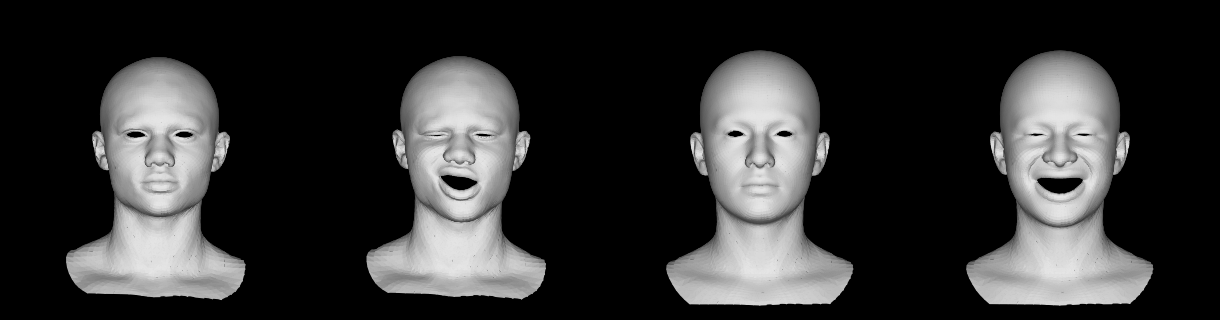

In [417]:
# v_list = [src_v, src_motion, tgt_v, new_v1+tgt_v, new_v2-(src_v-tgt_v)]
# v_list = [src_v, src_motion, tgt_v, new_v1+tgt_v, gt_frames[0], char_v, char_v+new_char_v1]
FRAME=145
# v_list = [src_v, src_d_rtg[FRAME]+src_v, ict_model.neutral_verts, gt_frames[FRAME]]
v_list = [src_v, src_v+new_v1, ict_model.neutral_verts, gt_frames[FRAME]]
v_list = [v*.5 for v in v_list]
f_list = [src_f, src_f, tgt_f, tgt_f, tgt_f, src_f, src_f, src_f]
size = 3
rot_list = [[0,0,0]]*len(v_list)
plot_image_array(v_list, f_list, rot_list, size=size, mode='shade')

In [369]:
from scipy.sparse import csr_matrix, vstack, hstack

def add_one_hot_row(L, index, n=None, sq=False):
    if n is None:
        n = L.shape[1]

    # one-hot vector를 sparse row로 만들기
    row = csr_matrix(([1.0], ([0], [index])), shape=(1, n))
    
    # row-wise stack
    L_extended =  vstack([L, row])

    if sq:
        # append zero column → shape (n+1, n+1)
        zero_col = csr_matrix(([1.0], ([n], [0])), shape=(n + 1, 1))  # all zeros
        L_extended = hstack([L_extended, zero_col])
    return L_extended

def add_zero_row(L, n=None):
    if n is None:
        n = L.shape[1]

    # one-hot vector를 sparse row로 만들기
    row = csr_matrix((1, n))
    
    # row-wise stack
    L_extended =  vstack([L, row])

    # append zero column → shape (n+1, n+1)
    zero_col = csr_matrix((n + 1, 1))  # all zeros
    L_square = hstack([L_extended, zero_col])
    return L_square


def add_anchor(L, indices):
    nr, nc = L.shape
    n = indices.shape[0]

    ## padding
    row = csr_matrix((n, nc))
    L_extended = vstack([L, row])

    ## ones
    one_col = csr_matrix((np.ones(n), (nr+np.arange(n), np.arange(n))), shape=(nr+n, n))
    L_extended = hstack([L_extended, one_col], format='csr')
    
    return L_extended

def make_custom_diag(n):
    diagonals = []

    # main diag
    main_diag = np.zeros(n)
    main_diag[1:-1] = -1
    diagonals.append(main_diag)

    # upper diag
    upper_diag = np.zeros(n)
    upper_diag[1:-2] = 0.5  # from last ~ last-2nd
    diagonals.append(upper_diag)

    # lower diag
    lower_diag = np.zeros(n)
    lower_diag[2:-1] = 0.5  # from 1st ~ 2nd
    diagonals.append(lower_diag)

    offsets = [0, 1, -1]

    return diags(diagonals, offsets, shape=(n, n), format='csr')

def make_full_diag(n):
    main_diag = -1 * np.ones(n)
    upper_diag = 0.5 * np.ones(n - 1)
    lower_diag = 0.5 * np.ones(n - 1)

    # offsets: 0 (main), 1 (upper), -1 (lower)
    return diags(
        diagonals=[lower_diag, main_diag, upper_diag],
        offsets=[-1, 0, 1],
        shape=(n, n),
        format='csr'
    )

In [411]:
# gt_frames = torch.load("gt_frames.pth")
gt_frames = torch.load("gt_frames.pth")[:200].numpy()
delta_frames = gt_frames - ict_model.neutral_verts
#gt_mean = gt_frames.mean(1)[:, None] - ict_model.neutral_verts.mean(0)
delta_frames_mean = delta_frames.mean(1)[:, None]
gt_l = igl.cotmatrix(ict_model.neutral_verts, ict_model.faces)

print(delta_frames_mean.shape)

(200, 1, 3)


In [313]:
# delta_frames.min(1).shape[0]
delta_frames_nrm = np.linalg.norm(delta_frames, axis=-1)
delta_anc_idx = delta_frames_nrm.argmin(1) # indicies that has least displacement in each frame
delta_anc_idx = np.array(list(set(delta_anc_idx))) # remove duplicates
print(delta_anc_idx.shape)
# abs(delta_frames).argmin(2)

(200,)


(202, 202)


In [280]:
# delta_frames.reshape(delta_frames.shape[0], -1).shape # (200, 33744)
padd = np.zeros((1, *delta_frames.shape[1:]))
print(padd.shape)

L_time = make_full_diag(gt_frames.shape[0]+2)
delta_frames_cnt = np.concatenate((padd, delta_frames, padd),axis=0)
d_Lt = L_time @ delta_frames_cnt.reshape(delta_frames_cnt.shape[0], -1)

(1, 11248, 3)


In [353]:
delta_anc_idx = np.array(list(set(delta_anc_idx)))

In [420]:
src_d_rtg=[]

# # original
for d_f in gt_frames:
    # solve delta
    tmp_v = spsolve(src_l, gt_l@d_f)
    src_d_rtg.append(tmp_v)
    
src_d_rtg = np.array(src_d_rtg)
print(src_d_rtg.shape)

(200, 11248, 3)


In [422]:
# list for solved per-frame source deltas
src_d_rtg=[]

# original
for d_f in delta_frames:
    # solve delta
    tmp_v = spsolve(src_l, gt_l@d_f)
    src_d_rtg.append(tmp_v)
    
# original + boundary
# for d_f, b_i in zip(delta_frames, delta_anc_idx):
#     tmp_l = add_one_hot_row(src_l, b_i, sq=True)
#     tmp_gt_l = add_one_hot_row(gt_l, b_i)
#     tmp_v = spsolve(tmp_l, tmp_gt_l@d_f)
#     src_d_rtg.append(tmp_v[:-1])
    

# # original + boundary 2
# n_bc = delta_anc_idx.shape[0]
# tmp_l = add_anchor(src_l, delta_anc_idx)
# for idx, d_f in enumerate(delta_frames):    
#     tmp_d_f = gt_l@d_f
#     tmp_d_f = np.concatenate((tmp_d_f, gt_frames[idx, delta_anc_idx]) )
#     tmp_v = spsolve(tmp_l, tmp_d_f)
#     src_d_rtg.append(tmp_v[:-n_bc])

# # delta in time
# for d_f in d_Lt.reshape(d_Lt.shape[0], -1, 3):
#     # solve delta
#     tmp_v = spsolve(src_l, gt_l@d_f)
#     src_d_rtg.append(tmp_v)

src_d_rtg = np.array(src_d_rtg)
print(src_d_rtg.shape)

(200, 11248, 3)


In [401]:
# np.concatenate((tmp_v[-45:] , gt_frames[idx, delta_anc_idx] ),axis=-1)

In [345]:
tmp_l = add_one_hot_row(src_l, b_i, sq=True)
tmp_gt_l = add_one_hot_row(gt_l, b_i)
# tmp_gt_l = add_zero_row(gt_l)
# tmp_d_f = np.concatenate((d_f,np.zeros((1, 3)) ))
tmp_v = spsolve(tmp_l, tmp_gt_l@d_f)
tmp_v.shape

(11249, 3)

In [356]:
tmp_l.shape

(11249, 11249)

In [346]:
# src_d_rtg.shape

In [259]:
src_d_rtg_recon = spsolve(L_time, src_d_rtg.reshape(src_d_rtg.shape[0],-1))
src_d_rtg_recon = src_d_rtg_recon.reshape(src_d_rtg_recon.shape[0], -1, 3)

In [264]:
src_d_rtg_recon = src_d_rtg_recon[1:-1]

In [265]:
print(src_d_rtg_recon.shape)

(200, 11248, 3)


In [187]:
# list for solved per-frame source deltas
src_d_rtg=[]

for d_f in delta_frames:
    # solve delta
    tmp_v = spsolve(src_l, gt_l@d_f)
    src_d_rtg.append(tmp_v)


In [ ]:
# import numpy as np
# from scipy.linalg import lu_factor, lu_solve
# A = np.array([[2, 5, 8, 7], [5, 2, 2, 8], [7, 5, 6, 6], [5, 4, 4, 8]])
# b = np.array([1, 1, 1, 1])
# lu, piv = lu_factor(A)
# x = lu_solve((lu, piv), b)
# np.allclose(A @ x - b, np.zeros((4,)))

In [197]:
from IPython.display import Video

In [439]:
# src_d_rtg2 = src_d_rtg - src_d_rtg[:, delta_anc_idx].mean(1)[:,None] + src_v[delta_anc_idx].mean(0)
src_d_rtg3 = src_d_rtg - src_d_rtg.mean(1)[:,None] #+ src_v.mean(0)

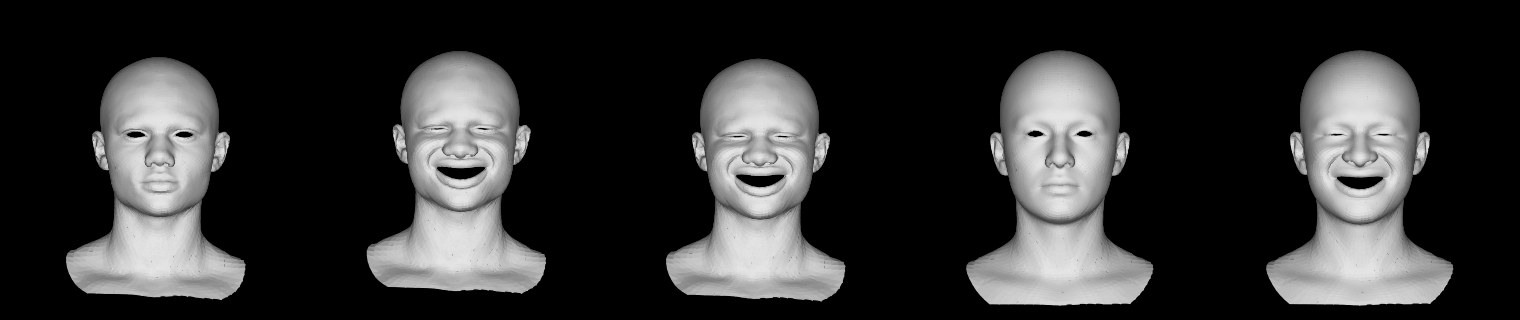

In [441]:
# v_list = [src_v, src_motion, tgt_v, new_v1+tgt_v, new_v2-(src_v-tgt_v)]
# v_list = [src_v, src_motion, tgt_v, new_v1+tgt_v, gt_frames[0], char_v, char_v+new_char_v1]
FRAME=150
v_list = [src_v, src_d_rtg[FRAME]+src_v, src_d_rtg3[FRAME]+src_v, ict_model.neutral_verts, gt_frames[FRAME]]
# v_list = [src_v, src_d_rtg[FRAME], ict_model.neutral_verts, gt_frames[FRAME]]
# v_list = [src_v, src_d_rtg2[FRAME]+src_v, ict_model.neutral_verts, gt_frames[FRAME]]

# v_list = [src_v, src_d_rtg_recon[FRAME]+src_v, ict_model.neutral_verts, gt_frames[FRAME]]
v_list = [v*.5 for v in v_list]
f_list = [src_f, src_f, tgt_f, tgt_f, tgt_f, src_f, src_f, src_f]
size = 3
rot_list = [[0,0,0]]*len(v_list)
plot_image_array(v_list, f_list, rot_list, size=size, mode='shade')

/source/sihun/NFS/utils/matplotlib_rnd.py:1524: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
rendering: 100%|██████████| 200/200 [01:01<00:00,  3.23it/s]


saved as: tmp/test_df_bc-sub_mean2.mp4


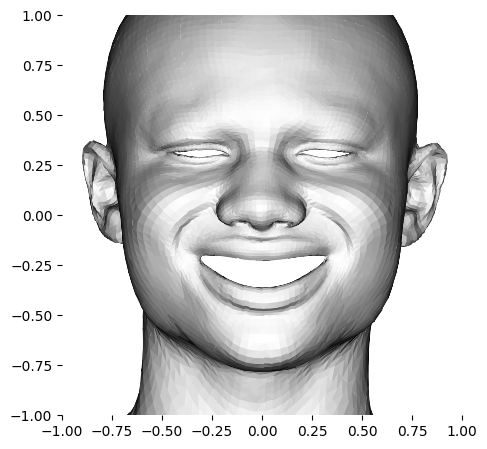

In [442]:
savename='test_df_bc-sub_mean2'
# render_wo_audio(Vs=[v+src_v for v in src_d_rtg], F=ict_model.faces, size=4, mode='shade', savename=savename)
render_wo_audio(Vs=[v+src_v for v in src_d_rtg2], F=ict_model.faces, size=4, mode='shade', savename=savename)
# render_wo_audio(Vs=gt_frames[:200], F=ict_model.faces, size=4, mode='shade', savename='test_gt_df')
# render_wo_audio(Vs=[v+src_v for v in src_d_rtg_recon], F=ict_model.faces, size=4, mode='shade', savename='test_df')

In [443]:
# Video("tmp/test_df_bc.mp4")
# Video("tmp/test_df_bc2.mp4")
Video("tmp/test_df_bc-sub_mean2.mp4")

In [399]:
Video("tmp/test_gt_df.mp4")